<a href="https://colab.research.google.com/github/codebluecruz/Hyper-Parameter-Optimization-of-Decision-Tree-/blob/master/Final_operations1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [43]:
sdss_df = pd.read_csv('Romcom.csv', skiprows=0)

In [44]:
sdss_df.head()

,UniqueId,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount,Sentiment_Rating
0,1,75 or over,Incomplete or Infrequent Bowel Movements,11/23/2009,miralax 17 gram oral powder packet,17116,5,3,"I have success taking this drug, but have had ...",4,Female,"Nausea , abdominal cramping, or gas may occur.",13,4
1,2,55-64,Rheumatoid Arthritis,11-01-2010,meloxicam,911,4,4,unfortunately this drug causes me migrane like...,2,Female,"Stomach upset, nausea , dizziness , or dia...",3,1
2,3,65-74,Sensation of Spinning or Whirling,3/19/2008,meclizine hcl,4520,4,4,"diagnosed with vertigo, this medication taken ...",4,Male,"Drowsiness, dry mouth , and tiredness may occur.",10,4
3,4,25-34,Depression,03-02-2011,mirtazapine tablet,13706,3,1,Placed on this medicine after being taken off ...,1,Female,"Dizziness , drowsiness, lightheadedness , inc...",20,1
4,5,19-24,Depression,04-01-2011,mirtazapine,13706,3,1,i have only been on this drug for one week. I ...,1,Female,"Dizziness , drowsiness, lightheadedness , inc...",28,1


In [45]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29998 entries, 0 to 29997
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   UniqueId          29998 non-null  int64 
 1   Age               29998 non-null  object
 2   Condition         29998 non-null  object
 3   Date              29998 non-null  object
 4   Drug              29998 non-null  object
 5   DrugId            29998 non-null  int64 
 6   EaseofUse         29998 non-null  int64 
 7   Effectiveness     29998 non-null  int64 
 8   Reviews           29998 non-null  object
 9   Satisfaction      29998 non-null  int64 
 10  Sex               29998 non-null  object
 11  Sides             29998 non-null  object
 12  UsefulCount       29998 non-null  int64 
 13  Sentiment_Rating  29998 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 3.2+ MB


In [46]:
sdss_df.describe()

,UniqueId,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount,Sentiment_Rating
count,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000
mean,14999.500000,30174.666444,3.987366,3.665778,3.152577,6.708747,3.164944
std,8659.821024,49354.867556,1.364891,1.438950,1.618441,9.935583,1.721518
min,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7500.250000,6007.000000,3.000000,3.000000,1.000000,1.000000,1.000000
50%,14999.500000,6997.000000,5.000000,4.000000,3.000000,3.000000,3.000000
75%,22498.750000,19937.000000,5.000000,5.000000,5.000000,9.000000,5.000000
max,29998.000000,177317.000000,5.000000,5.000000,5.000000,178.000000,5.000000


In [47]:
sdss_df['Satisfaction'].value_counts()

5    9587
1    8246
4    4917
3    4226
2    3022
Name: Satisfaction, dtype: int64

In [48]:
sdss_df.columns.values

array(['UniqueId', 'Age', 'Condition', 'Date', 'Drug', 'DrugId',
       'EaseofUse', 'Effectiveness', 'Reviews', 'Satisfaction', 'Sex',
       'Sides', 'UsefulCount', 'Sentiment_Rating'], dtype=object)

In [49]:
sdss_df.drop(['UniqueId', 'Age', 'Date', 'DrugId', 'Reviews', 'Sex', 'Sides', 'Condition', 'Drug'], axis=1, inplace=True)
sdss_df.head(1)

,EaseofUse,Effectiveness,Satisfaction,UsefulCount,Sentiment_Rating
0,5,3,4,13,4


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:2613: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)


Text(0.5, 1.0, 'EaseofUSe')

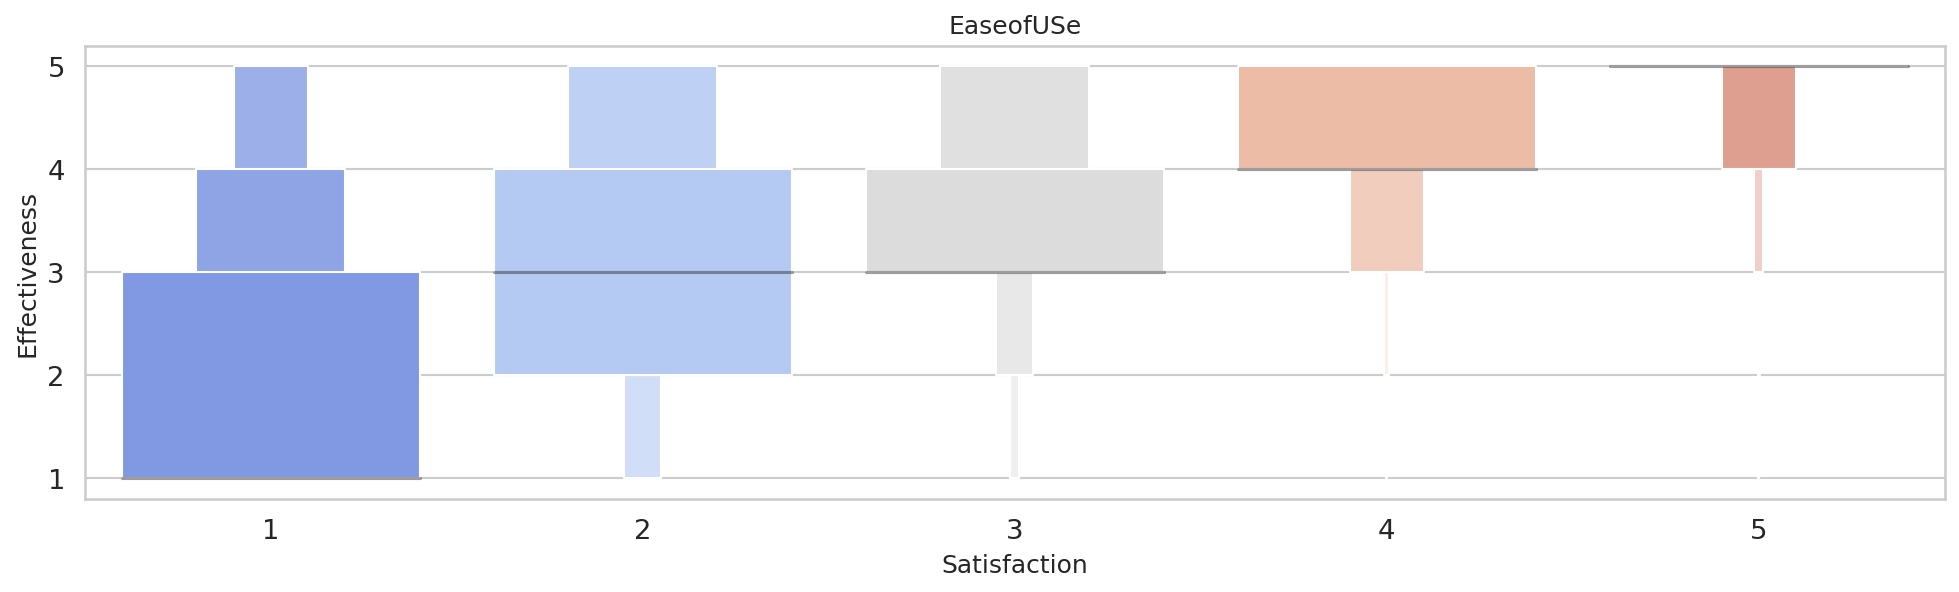

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.lvplot(x=sdss_df['Satisfaction'], y=sdss_df['Effectiveness'], palette='coolwarm')
ax.set_title('EaseofUSe')

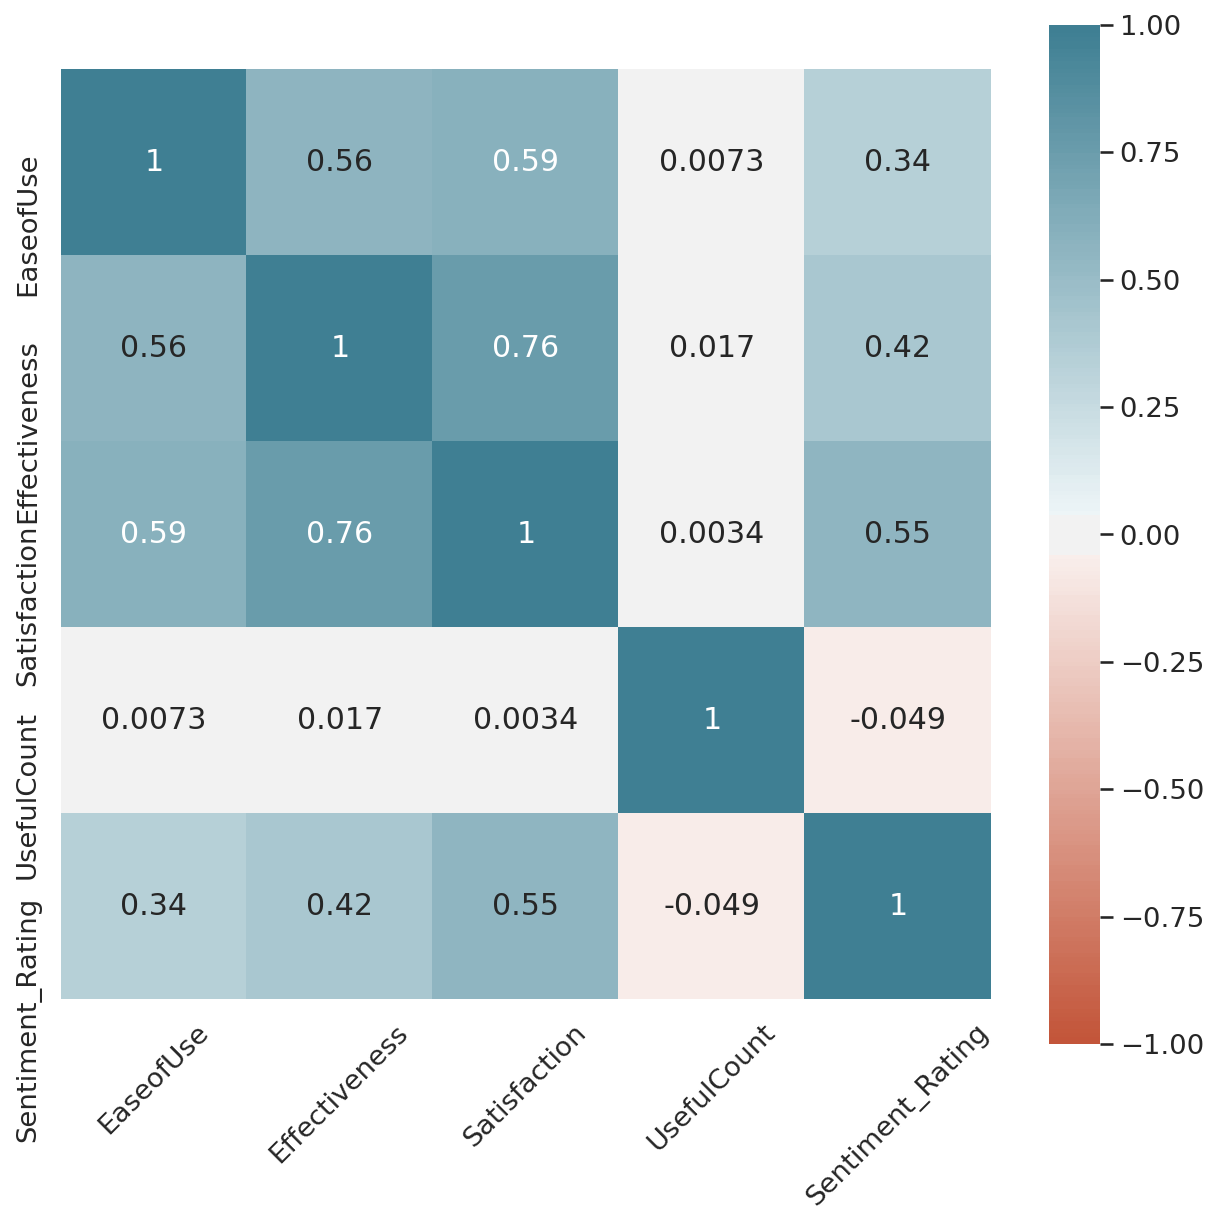

In [51]:
import seaborn as sns
# Heatmap of the correlation matrix
plt.rcParams['figure.figsize'] = [10,9]
sns.set(font_scale = 1.2)
corr = sdss_df.select_dtypes(include = 'int64').corr()
sns_heat = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(20, 220, n=200), square=True);
plt.setp(sns_heat.get_xticklabels(), rotation = 45);

In [121]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['Satisfaction'])
sdss_df_fe['Satisfaction'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['EaseofUse', 'Effectiveness', 'UsefulCount', 'Sentiment_Rating']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
#sdss_df_fe.drop(['EaseofUse', 'Effectiveness', 'UsefulCount', 'Sentiment_Rating'], axis=1, inplace=True)
sdss_df_fe.drop(['PCA_1', 'PCA_2', 'PCA_3'], axis=1, inplace=True)
sdss_df_fe.head()

,EaseofUse,Effectiveness,Satisfaction,UsefulCount,Sentiment_Rating
0,5,3,3,13,4
1,4,4,1,3,1
2,4,4,3,10,4
3,3,1,0,20,1
4,3,1,0,28,1


In [122]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('Satisfaction', axis=1))


In [123]:
X_train, X_test, y_train, y_test = train_test_split(sdss, sdss_df_fe['Satisfaction'], test_size=0.33)

In [124]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 62.06
Time consumed for training: 0.055 seconds
Time consumed for prediction: 0.34563 seconds


In [125]:
from sklearn.preprocessing import MaxAbsScaler
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(sdss_df_fe.drop('Satisfaction', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, sdss_df_fe['Satisfaction'], test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train_gnb, y_train_gnb)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test_gnb)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 64.49
Time consumed for training: 0.008 seconds
Time consumed for prediction: 0.00502 seconds


In [126]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 66.74
Time consumed for training: 2.558
Time consumed for prediction: 0.14735 seconds


In [127]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 66.77
Time consumed for training: 0.127 seconds
Time consumed for prediction: 0.01865 seconds


In [128]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))


Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 66.49
Time consumed for training: 13.205 seconds
Time consumed for prediction: 3.59674 seconds


In [157]:
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)

training_start = time.perf_counter()
gbk.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gbk.predict(X_test)
prediction_end = time.perf_counter()
acc_gbk = (preds == y_test).sum().astype(float) / len(preds)*100
gbk_train_time = training_end-training_start
gbk_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_gbk))
print("Time consumed for training: %4.3f seconds" % (gbk_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gbk_prediction_time))



Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 66.48
Time consumed for training: 6.706 seconds
Time consumed for prediction: 0.09992 seconds


In [162]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)


gbkpred = gbk.predict(X_test)
print(confusion_matrix(y_test, gbkpred ))
print(round(accuracy_score(y_test, gbkpred),2)*100)
GBKCV = (cross_val_score(gbk, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())


[[2164   82  160   81  143]
 [ 425  120  255  106  124]
 [ 258   36  559  307  219]
 [ 114    9  154  914  448]
 [  35    5   43  314 2825]]
66.0


In [129]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
training_start = time.perf_counter()
LR.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = LR.predict(X_test)
prediction_end = time.perf_counter()
acc_LR = (preds == y_test).sum().astype(float) / len(preds)*100
LR_train_time = training_end-training_start
LR_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_LR))
print("Time consumed for training: %4.3f seconds" % (LR_train_time))
print("Time consumed for prediction: %6.5f seconds" % (LR_prediction_time))


Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 66.49
Time consumed for training: 13.205 seconds
Time consumed for prediction: 3.59674 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [163]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC', 'LR', 'gbk'],
    'Score': [acc_knn, acc_gnb, acc_xgb, acc_rfc, acc_svc, acc_LR, acc_gbk],
    'Runtime Training': [knn_train_time, gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time, LR_train_time, gbk_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time, LR_prediction_time, gbk_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
Random Forest,66.767677,0.127160,0.018649
XGBoost,66.737374,2.558241,0.147354
SVC,66.494949,13.205366,3.596741
gbk,66.484848,6.706490,0.099916
Naive Bayes,64.494949,0.008480,0.005015
LR,63.262626,1.528029,0.001298
KNN,62.060606,0.055474,0.345633


In [131]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.66567164 0.65970149 0.65472637 0.64477612 0.67164179 0.65920398
 0.66119403 0.68308458 0.65953211 0.6545545 ]
Mean: 0.6614086610253859
Standard Deviation: 0.009860790028841557


In [132]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.66218905 0.65174129 0.65771144 0.64577114 0.66368159 0.64776119
 0.66169154 0.67761194 0.65156794 0.66102539]
Mean: 0.6580752533995032
Standard Deviation: 0.008900476142604166


In [133]:
importances = pd.DataFrame({
    'Feature': sdss_df_fe.drop('Satisfaction', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
Effectiveness,0.709244
Sentiment_Rating,0.169104
EaseofUse,0.106085
UsefulCount,0.015567


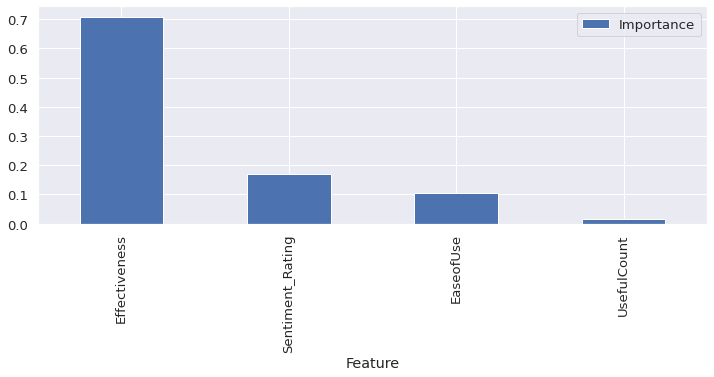

In [134]:
importances.plot.bar()

In [180]:
xgb_cv = XGBClassifier(n_estimators=100)
score = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print(score)

from sklearn.model_selection import KFold

# Defining Features and splitting the data as train and test set
features = sdss_df_fe[['EaseofUse', 'Effectiveness', 'UsefulCount', 'Sentiment_Rating']]
target = sdss_df_fe['Satisfaction']
target.isnull().sum().sum()
features = features.fillna(features.mean())
features.isnull().sum().sum()
train_data, test_data, train_targets, test_targets = train_test_split(features, target, test_size = 0.3, shuffle=True, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)
num_folds=2
random_state=42
n_iter=50
kf = KFold(n_splits=num_folds, random_state=random_state)

[0.65870647 0.64726368 0.6761194  0.660199   0.67412935 0.65373134
 0.66069652 0.660199   0.66699851 0.64559482]
The Train set size  (20098, 4)
The Test set size  (9900, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [178]:
X_train

,EaseofUse,Effectiveness,UsefulCount,Sentiment_Rating
18590,4,5,0,1
25107,1,1,4,1
27838,5,5,4,5
9014,5,5,7,5
26683,4,4,6,5
...,...,...,...,...
27166,1,1,0,5
20762,5,4,1,3
13063,5,5,2,4
346,5,1,2,5


ValueError: ignored

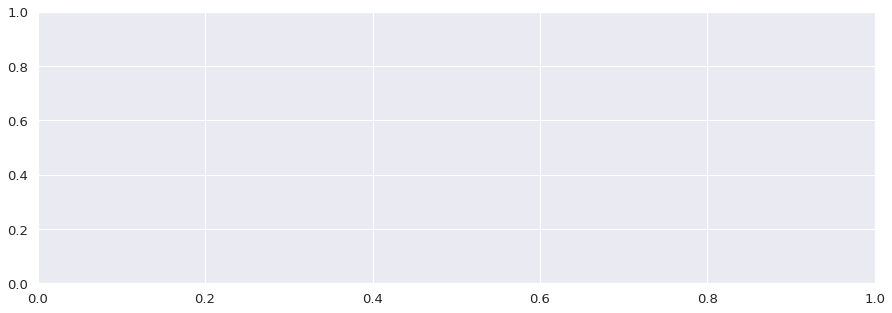

In [181]:
# XGBOOST ROC/ AUC , BEST MODEL
from sklearn import metrics
fig, (ax) = plt.subplots(nrows = 1, ncols = 1, figsize = (15,5))
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fprxgb, tprxgb, thresholdxgb = metrics.roc_curve(y_test, preds)
roc_aucxgb = metrics.auc(fprxgb, tprxgb)

ax.plot(fprxgb, tprxgb, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('Receiver Operating Characteristic XGBOOST ',fontsize=10)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.legend(loc = 'lower right', prop={'size': 16})


In [138]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid={'learning_rate': np.logspace(-3, -1, 3),
'max_depth': np.linspace(5,12,3,dtype = int),
'n_estimators': np.linspace(800,1200,3, dtype = int),
'random_state': [random_state]}
gs=GridSearchCV(xgb_cv, param_grid, scoring="accuracy", n_jobs=-1, cv=kf, verbose=False)
gs.fit(train_data, train_targets)
#gs_test_score=accuracy(test_targets, gs.predict(test_data))
print("Best accuracy {:.3f} params {}".format(gs.best_score_, gs.best_params_))


Best accuracy 0.664 params {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'random_state': 42}
CPU times: user 42.8 s, sys: 187 ms, total: 43 s
Wall time: 34min 8s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb174d27b00>,
      dtype=object)

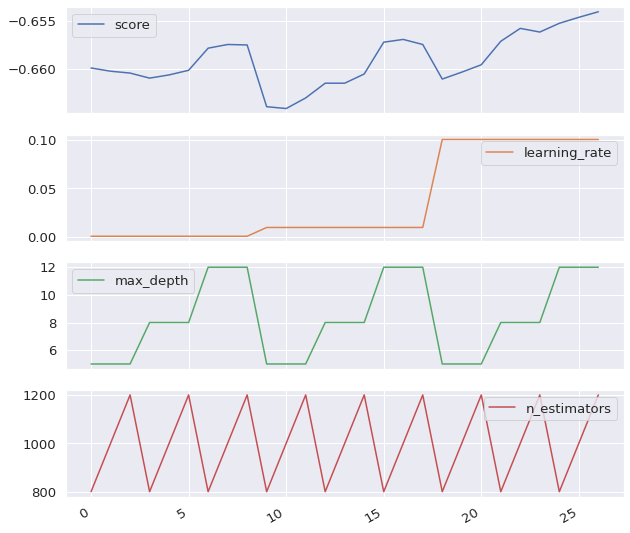

In [139]:
gs_results_df=pd.DataFrame(np.transpose([-gs.cv_results_['mean_test_score'],
gs.cv_results_['param_learning_rate'].data,
gs.cv_results_['param_max_depth'].data,
gs.cv_results_['param_n_estimators'].data]),
columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

In [140]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_grid_rand={'learning_rate': np.logspace(-5, 0, 100),
'max_depth': randint(2,20),
'n_estimators': randint(100,2000),
'random_state': [random_state]}
rs=RandomizedSearchCV(xgb_cv, param_grid_rand, n_iter = n_iter, scoring="accuracy", n_jobs=-1, cv=kf, verbose=False, random_state=random_state)
rs.fit(train_data, train_targets)
#rs_test_score=mean_squared_error(test_targets, rs.predict(test_data))
print("Best accuracy {:.3f} params {}".format(rs.best_score_, rs.best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best accuracy 0.663 params {'learning_rate': 0.012045035402587823, 'max_depth': 5, 'n_estimators': 369, 'random_state': 42}
CPU times: user 17.6 s, sys: 154 ms, total: 17.7 s
Wall time: 1h 23min 11s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb174d6e5c0>,
      dtype=object)

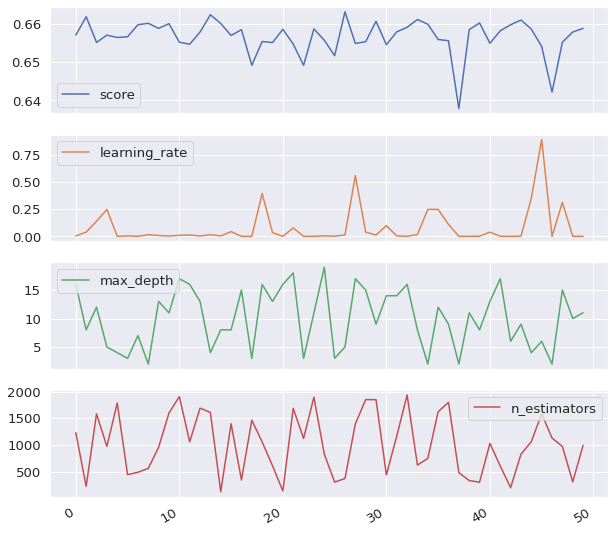

In [141]:
rs_results_df=pd.DataFrame(np.transpose([rs.cv_results_['mean_test_score'],
rs.cv_results_['param_learning_rate'].data,
rs.cv_results_['param_max_depth'].data,
rs.cv_results_['param_n_estimators'].data]),
columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

Text(0, 0.5, 'best_cumulative_score')

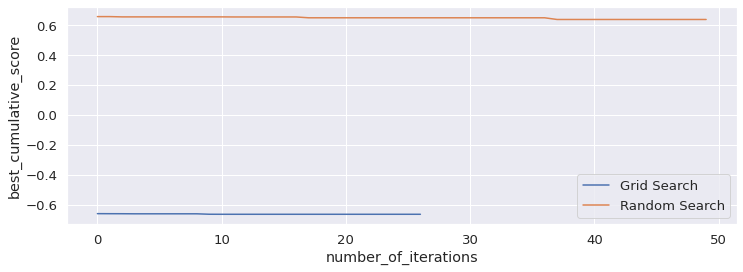

In [142]:
scores_df=pd.DataFrame(index=range(n_iter))
scores_df['Grid Search']=gs_results_df['score'].cummin()
scores_df['Random Search']=rs_results_df['score'].cummin()

ax = scores_df.plot()
ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")

In [143]:
print('Test accuracy scored:')
print("Grid Search {:.3f}".format(gs.best_score_))
print("Random Search {:.3f}".format(rs.best_score_))

Test accuracy scored:
Grid Search 0.664
Random Search 0.663


In [144]:
X_train, X_test, y_train, y_test = train_test_split(sdss_df_fe.drop('Satisfaction', axis=1), sdss_df_fe['Satisfaction'],test_size=0.33)

In [151]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=1000, random_state=42)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

XGBoost's prediction accuracy WITH optimal hyperparameters is: 66.66


In [152]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.65870647 0.64726368 0.6761194  0.660199   0.67412935 0.65373134
 0.66069652 0.660199   0.66699851 0.64559482]
Mean: 0.6603638106134335
Standard Deviation: 0.009583244951347415


In [153]:
unique, counts = np.unique(sdss_df_fe['Satisfaction'], return_counts=True)
dict(zip(unique, counts))

{0: 8246, 1: 3022, 2: 4226, 3: 4917, 4: 9587}

In [154]:
predictions = cross_val_predict(xgb, sdss_df_fe.drop('Satisfaction', axis=1), sdss_df_fe['Satisfaction'], cv=3)
confusion_matrix(sdss_df_fe['Satisfaction'], predictions)

array([[6665,  224,  503,  335,  519],
       [1287,  277,  760,  352,  346],
       [ 801,  127, 1646,  962,  690],
       [ 310,   28,  488, 2763, 1328],
       [ 107,    9,  123,  967, 8381]])

In [155]:
print("Precision:", precision_score(sdss_df_fe['Satisfaction'], predictions, average='micro'))
print("Recall:",recall_score(sdss_df_fe['Satisfaction'], predictions, average='micro'))

Precision: 0.6577771851456764
Recall: 0.6577771851456764


In [156]:
print("F1-Score:", f1_score(sdss_df_fe['Satisfaction'], predictions, average='micro'))

F1-Score: 0.6577771851456764
